# Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write your Algorithm
* [Step 6](#step6): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

Make sure that you've downloaded the required human and dog datasets:
* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).  Unzip the folder and place it in this project's home directory, at the location `/dog_images`. 

* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  Unzip the folder and place it in the home directory, at location `/lfw`.  

*Note: If you are using a Windows machine, you are encouraged to use [7zip](http://www.7-zip.org/) to extract the folder.*

In the code cell below, we save the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.

In [1]:
import numpy as np
from glob import glob
import torch
import torchvision.models as models
from torch.autograd import Variable

import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline

from PIL import Image, ImageFile
import torchvision.transforms as transforms

import os
import numpy as np
import torchvision

import torch.nn as nn
import torch.nn.functional as F

# check if CUDA is available
use_cuda = torch.cuda.is_available()

In [2]:
# load filenames for human and dog images
human_files = np.array(glob("/data/lfw/*/*"))
dog_files = np.array(glob("/data/dog_images/*/*/*"))

# print number of images in each dataset
print(dog_files[0])
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

/data/dog_images/train/103.Mastiff/Mastiff_06833.jpg
There are 13233 total human images.
There are 8351 total dog images.


<a id='step1'></a>
## Step 1: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


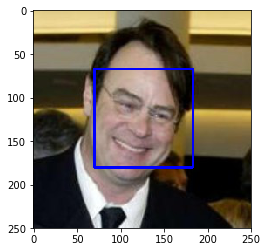

In [3]:

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[0])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [4]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 
(You can print out your results and/or write your percentages in this cell)

In [5]:
from tqdm import tqdm

human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

#-#-# Do NOT modify the code above this line. #-#-#

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
no_of_human_face = 0
no_of_dog_face = 0

for human_file in human_files_short:
    no_of_human_face += face_detector(human_file)

for dog_file in dog_files_short:
    no_of_dog_face += face_detector(dog_file)

print('What percentage of the first 100 images in human_files have a detected human face? - {}%'
      .format((no_of_human_face/100) * 100))
print('What percentage of the first 100 images in dog_files have a detected human face? - {}%'
      .format((no_of_dog_face/100) * 100))

What percentage of the first 100 images in human_files have a detected human face? - 98.0%
What percentage of the first 100 images in dog_files have a detected human face? - 17.0%


We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [82]:
### (Optional) 
### TODO: Test performance of anotherface detection algorithm.
### Feel free to use as many code cells as needed.
import os

d = '/data/dog_images/test/035.Boykin_spaniel'
l = [os.path.join(d, o) for o in os.listdir(d)]
print(len(l))
print(l)

6
['/data/dog_images/test/035.Boykin_spaniel/Boykin_spaniel_02500.jpg', '/data/dog_images/test/035.Boykin_spaniel/Boykin_spaniel_02484.jpg', '/data/dog_images/test/035.Boykin_spaniel/Boykin_spaniel_02501.jpg', '/data/dog_images/test/035.Boykin_spaniel/Boykin_spaniel_02496.jpg', '/data/dog_images/test/035.Boykin_spaniel/Boykin_spaniel_02497.jpg', '/data/dog_images/test/035.Boykin_spaniel/Boykin_spaniel_02441.jpg']


---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [6]:

# define VGG16 model
VGG16 = models.vgg16(pretrained=True)
resnet50 = models.resnet50(pretrained=True)
inception_v3 = models.inception_v3(pretrained=True)

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()
    resnet50 = resnet50.cuda()
    inception_v3 = inception_v3.cuda()

print(VGG16)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:17<00:00, 31738812.01it/s] 
Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.torch/models/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:04<00:00, 23268508.39it/s]
Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.torch/models/inception_v3_google-1a9a5a14.pth
100%|██████████| 108857766/108857766 [00:01<00:00, 84449579.56it/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### (IMPLEMENTATION) Making Predictions with a Pre-trained Model

In the next code cell, you will write a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

Before writing the function, make sure that you take the time to learn  how to appropriately pre-process tensors for pre-trained models in the [PyTorch documentation](http://pytorch.org/docs/stable/torchvision/models.html).

In [7]:
def VGG16_predict(img_path):
    # VGG16.eval()
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    ## TODO: Complete the function.
    ## Load and pre-process an image from the given img_path
    ## Return the *index* of the predicted class for that image
    # VGG-16 Takes 224x224 images as input, so we resize all of them
    data_transform = transforms.Compose([transforms.Resize(224), 
                                         transforms.CenterCrop(224), 
                                         transforms.RandomRotation(30), 
                                         transforms.ToTensor()])
    # train_data = datasets.ImageFolder(train_dir, transform=data_transform)
    # train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
    image = Image.open(img_path)
    image = data_transform(image).float()
    image = torch.tensor(image, requires_grad=True, dtype=torch.float)
    image = image.unsqueeze(0)
    if use_cuda:
        image = image.cuda()
    VGG16.eval()
    
    # img = cv2.imread(img_path)
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # dim = (224, 224)
    # perform the actual resizing of the image and show it
    # img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    # data = torch.from_numpy(np.array(img))
    # data = torch.tensor(img, requires_grad=True, dtype=torch.float)
    # data = data.unsqueeze(0)
    # data = Variable(data)
    
    # print(image)
    output = VGG16(image)
    # print(output)
    values, indices = output.max(1)
    # print(values)
    return indices.item() # predicted class index

def resnet50_predict(img_path):
    
    data_transform = transforms.Compose([transforms.Resize(224), 
                                         transforms.CenterCrop(224), 
                                         transforms.Grayscale(num_output_channels=3), 
                                         transforms.ToTensor()])
    
    image = Image.open(img_path)
    image = data_transform(image).float()
    image = torch.tensor(image, requires_grad=False, dtype=torch.float)
    image = image.unsqueeze(0)
    if use_cuda:
        image = image.cuda()
    resnet50.eval()
    # print(image)
    output = resnet50(image)
    # print(output)
    values, indices = output.max(1)
    # print(values)
    return indices.item() # predicted class index

def inception_v3_predict(img_path):
    
    data_transform = transforms.Compose([transforms.Resize(299), 
                                         transforms.CenterCrop(299), 
                                         transforms.RandomRotation(30), 
                                         transforms.ToTensor()])
    
    image = Image.open(img_path)
    image = data_transform(image).float()
    image = torch.tensor(image, requires_grad=True, dtype=torch.float)
    image = image.unsqueeze(0)
    if use_cuda:
        image = image.cuda()
    # print(image)
    inception_v3.eval()
    output = inception_v3(image)
    # print(output)
    values, indices = output.max(1)
    # print(values)
    return indices.item() # predicted class index

In [6]:
# /data/dog_images/train/103.Mastiff/Mastiff_06833.jpg
resnet50_predict('/data/dog_images/train/001.Affenpinscher/Affenpinscher_00001.jpg')

252

### (IMPLEMENTATION) Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

Use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [8]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    ## TODO: Complete the function.
    index = VGG16_predict(img_path)
    if index >= 151 and index <=268:
        return 1
    return 0 # true/false

def dog_detector_resnet50(img_path):
    ## TODO: Complete the function.
    index = resnet50_predict(img_path)
    if index >= 151 and index <=268:
        return 1
    return 0 # true/false

def dog_detector_inception_v3(img_path):
    ## TODO: Complete the function.
    index = inception_v3_predict(img_path)
    if index >= 151 and index <=268:
        return 1
    return 0 # true/false

### (IMPLEMENTATION) Assess the Dog Detector

__Question 2:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 

- percentage of the images in human_files_short have a detected human in VGG16? - 0.0%
- percentage of the images in dog_files_short have a detected dog in VGG16? - 71.0%
- percentage of the images in human_files_short have a detected human in resnet50? - 0.0%
- percentage of the images in dog_files_short have a detected dog in resnet50? - 96.0%
- percentage of the images in human_files_short have a detected human in inception_v3? - 1.0%
- percentage of the images in dog_files_short have a detected dog in inception_v3? - 98.0%

In [9]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.

no_of_human_face = 0
no_of_dog_face = 0

human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

for human_file in human_files_short:
    no_of_human_face += dog_detector(human_file)

for dog_file in dog_files_short:
    no_of_dog_face += dog_detector(dog_file)

print('What percentage of the images in human_files_short have a detected human in VGG16? - {}%'
      .format((no_of_human_face/100) * 100))
print('What percentage of the images in dog_files_short have a detected dog in VGG16? - {}%'
      .format((no_of_dog_face/100) * 100))

What percentage of the images in human_files_short have a detected human in VGG16? - 0.0%
What percentage of the images in dog_files_short have a detected dog in VGG16? - 74.0%


We suggest VGG-16 as a potential network to detect dog images in your algorithm, but you are free to explore other pre-trained networks (such as [Inception-v3](http://pytorch.org/docs/master/torchvision/models.html#inception-v3), [ResNet-50](http://pytorch.org/docs/master/torchvision/models.html#id3), etc).  Please use the code cell below to test other pre-trained PyTorch models.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [10]:
### (Optional) 
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.

no_of_human_face = 0
no_of_dog_face = 0

for human_file in human_files_short:
    no_of_human_face += dog_detector_resnet50(human_file)

for dog_file in dog_files_short:
    no_of_dog_face += dog_detector_resnet50(dog_file)

print('What percentage of the images in human_files_short have a detected human in resnet50? - {}%'
      .format((no_of_human_face/100) * 100))
print('What percentage of the images in dog_files_short have a detected dog in resnet50? - {}%'
      .format((no_of_dog_face/100) * 100))

What percentage of the images in human_files_short have a detected human in resnet50? - 0.0%
What percentage of the images in dog_files_short have a detected dog in resnet50? - 96.0%


In [10]:
### (Optional) 
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.

no_of_human_face = 0
no_of_dog_face = 0

for human_file in human_files_short:
    no_of_human_face += dog_detector_inception_v3(human_file)

for dog_file in dog_files_short:
    no_of_dog_face += dog_detector_inception_v3(dog_file)

print('What percentage of the images in human_files_short have a detected human in inception_v3? - {}%'
      .format((no_of_human_face/100) * 100))
print('What percentage of the images in dog_files_short have a detected dog in inception_v3? - {}%'
      .format((no_of_dog_face/100) * 100))

What percentage of the images in human_files_short have a detected human in inception_v3? - 0.0%
What percentage of the images in dog_files_short have a detected dog in inception_v3? - 97.0%


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 10%.  In Step 4 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dog_images/train`, `dog_images/valid`, and `dog_images/test`, respectively).  You may find [this documentation on custom datasets](http://pytorch.org/docs/stable/torchvision/datasets.html) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [26]:
ImageFile.LOAD_TRUNCATED_IMAGES = True
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20
# percentage of training set to use as validation
valid_size = 0.2
loaders_scratch = {}
# convert data to torch.FloatTensor
# transform = transforms.ToTensor()
transform = transforms.Compose([transforms.Resize(64), 
                                transforms.CenterCrop(64),
                                transforms.RandomRotation(30),
                                transforms.RandomVerticalFlip(),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])

transform_valid = transforms.Compose([transforms.Resize(64),
                                      transforms.CenterCrop(64),
                                 transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])

transform_test = transforms.Compose([transforms.Resize(64),
                                     transforms.CenterCrop(64),
                                     transforms.RandomVerticalFlip(),
                                 transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])
# choose the training and test datasets
train_data = torchvision.datasets.ImageFolder('/data/dog_images/train/', transform=transform)
valid_data = torchvision.datasets.ImageFolder('/data/dog_images/valid/', transform=transform)
test_data = torchvision.datasets.ImageFolder('/data/dog_images/test/', transform=transform)

# data_scratch = torchvision.datasets.ImageFolder('/data/dog_images/', ['train', 'valid', 'test'], transform=transform)
# loaders_scratch = torch.utils.data.DataLoader(data_scratch, batch_size=batch_size, shuffle=True, num_workers=num_workers)

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
# np.random.shuffle(indices)
# split = int(np.floor(valid_size * num_train))
# train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
# train_sampler = SubsetRandomSampler(train_idx)
# valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)

loaders_scratch['train'] = train_loader
loaders_scratch['valid'] = valid_loader
loaders_scratch['test'] = test_loader

In [15]:
## complete this function
def weights_init_normal(m):
    '''Takes in a module and initializes all linear layers with weight
       values taken from a normal distribution.'''
    
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        # get the number of the inputs
        n = m.in_features
        y = 1.0/np.sqrt(n)
        m.weight.data.normal_(0.0, y)
        m.bias.data.fill_(0)
    # for every Linear layer in a model
    # m.weight.data shoud be taken from a normal distribution
    # m.bias.data should be 0


**Question 3:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?


**Answer**: 
- I resized, corped the original image to 64px, initially i tried with 32px since this size may loose some image pixel may have data and validation loss will not reduced so i inceased to 128px since it need more level of convolutional layer and take more time to train so i reduced to 64px, which is suitable for this scenario (dog breed classifier)
- Yes i did, i did a randon rotation to 30 degree and Vertical flipping.

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  Use the template in the code cell below.

In [16]:
# model = inception_v3
# define the CNN architecture
class Net(nn.Module):
    ### TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        # convolutional layer
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv4 = nn.Conv2d(64, 128, 3, padding=1)
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(128 * 4 * 4, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 133)
        self.dropout = nn.Dropout(p=0.25)
        
        # self.m = nn.Sigmoid()
    
    def forward(self, x):
        ## Define forward behavior
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        # print(x.size())
        x = x.view(-1, 128 * 4 * 4)
        
        x = F.relu(self.fc1(x))        
        x = self.dropout(x)
        x = F.relu(self.fc2(x))        
        x = self.dropout(x)
        x = F.relu(self.fc3(x))        
        x = self.dropout(x)
     
        x = self.fc4(x)
        return x

#-#-# You so NOT have to modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

model_scratch.apply(weights_init_normal)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=133, bias=True)
  (dropout): Dropout(p=0.25)
)

__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__ 
- i created 3 level of convolutional layers 32, 64, and 128 to get extract more features. 
- input layer is 128 * 4 * 4 = 2048 neurons and 133 output neurons because we have 133 dog breeds to predict
- i created 3 level of Hidden layer each layers have 1024, 512, 256 neurons to improve the accuracy of result
- Relu is used for activation function
- And i initializes all linear layers with weight values taken from a normal distribution to get reduce validation loss and 

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and the optimizer as `optimizer_scratch` below.

In [17]:
import torch.optim as optim

# specify loss function
criterion_scratch = nn.CrossEntropyLoss()

# specify optimizer
optimizer_scratch = optim.SGD(model_scratch.parameters(), lr=0.01)

# for param in model_scratch.parameters():
    # param.requires_grad = True

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_scratch.pt'`.

In [32]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss      
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update training loss
            # train_loss += loss.item()*data.size(0)
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.item() - train_loss))
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss 
            # valid_loss += loss.item()*data.size(0)
            valid_loss += ((1 / (batch_idx + 1)) * (loss.item() - valid_loss))
        
        valid_loss = valid_loss/len(loaders['valid'].dataset)
        train_loss = train_loss/len(loaders['train'].dataset)
        
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
        # save model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
        
    # return trained model
    return model


In [33]:
model_scratch.load_state_dict(torch.load('model_scratch.pt'))
# train the model
model_scratch = train(40, loaders_scratch, model_scratch, optimizer_scratch, criterion_scratch, use_cuda, 'model_scratch.pt')

Epoch: 1 	Training Loss: 0.000561 	Validation Loss: 0.004754
Validation loss decreased (inf --> 0.004754).  Saving model ...
Epoch: 2 	Training Loss: 0.000559 	Validation Loss: 0.004732
Validation loss decreased (0.004754 --> 0.004732).  Saving model ...
Epoch: 3 	Training Loss: 0.000557 	Validation Loss: 0.004765
Epoch: 4 	Training Loss: 0.000553 	Validation Loss: 0.004730
Validation loss decreased (0.004732 --> 0.004730).  Saving model ...
Epoch: 5 	Training Loss: 0.000550 	Validation Loss: 0.004736
Epoch: 6 	Training Loss: 0.000548 	Validation Loss: 0.004760
Epoch: 7 	Training Loss: 0.000545 	Validation Loss: 0.004747
Epoch: 8 	Training Loss: 0.000543 	Validation Loss: 0.004701
Validation loss decreased (0.004730 --> 0.004701).  Saving model ...
Epoch: 9 	Training Loss: 0.000537 	Validation Loss: 0.004730
Epoch: 10 	Training Loss: 0.000537 	Validation Loss: 0.004713


### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images.  Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 10%.

In [34]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        
        ImageFile.LOAD_TRUNCATED_IMAGES = True
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))


In [35]:
# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

# call test function 
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 3.899578


Test Accuracy: 11% (95/836)


---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively). 

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [36]:
## TODO: Specify data loaders
import os
import torch
import numpy as np
import torchvision.models as models
from torch.autograd import Variable
import torchvision
from PIL import ImageFile
import torchvision.transforms as transforms

ImageFile.LOAD_TRUNCATED_IMAGES = True
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20
# percentage of training set to use as validation
valid_size = 0.2
loaders_transfer = {}
# convert data to torch.FloatTensor
# transform = transforms.ToTensor()
transform = transforms.Compose([transforms.Resize(224), 
                                transforms.CenterCrop(224),
                                transforms.RandomRotation(30),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])

transform_valid = transforms.Compose([transforms.Resize(224),
                                      transforms.CenterCrop(224),
                                 transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])

transform_test = transforms.Compose([transforms.Resize(224),
                                     transforms.CenterCrop(224),
                                 transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])
# choose the training and test datasets
train_data = torchvision.datasets.ImageFolder('/data/dog_images/train/', transform=transform)
valid_data = torchvision.datasets.ImageFolder('/data/dog_images/valid/', transform=transform)
test_data = torchvision.datasets.ImageFolder('/data/dog_images/test/', transform=transform_test)

# data_scratch = torchvision.datasets.ImageFolder('/data/dog_images/', ['train', 'valid', 'test'], transform=transform)
# loaders_scratch = torch.utils.data.DataLoader(data_scratch, batch_size=batch_size, shuffle=True, num_workers=num_workers)

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
# np.random.shuffle(indices)
# split = int(np.floor(valid_size * num_train))
# train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
# train_sampler = SubsetRandomSampler(train_idx)
# valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)

loaders_transfer['train'] = train_loader
loaders_transfer['valid'] = valid_loader
loaders_transfer['test'] = test_loader


### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify dog breed.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [37]:
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
## TODO: Specify model architecture 

model_transfer = models.vgg16(pretrained=True)

# Freeze training for all "features" layers
for param in model_transfer.features.parameters():
    param.requires_grad = False
    
custom_model = nn.Sequential(nn.Linear(25088, 1024), 
                  nn.ReLU(),
                  nn.Dropout(p=0.5), 
                  nn.Linear(1024, 512), 
                  nn.ReLU(),
                  nn.Dropout(p=0.5), 
                  nn.Linear(512, 133),
                 )

model_transfer.classifier = custom_model

if use_cuda:
    model_transfer = model_transfer.cuda()

print(model_transfer)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 
My initial CNN which i build from scratch has given only 11% test accuracy for 70 epoch. since it need more convolutional layer and training to get accurate result. instead of bulding new CNN we can use transfer learning with existing pretrained CNN and customized MLP for this scenario (Dog breed classification) 
- i choose VGG16 as a pretrained model 

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/master/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/master/optim.html).  Save the chosen loss function as `criterion_transfer`, and the optimizer as `optimizer_transfer` below.

In [38]:
import torch.optim as optim
# specify loss function (categorical cross-entropy)
criterion_transfer = nn.CrossEntropyLoss()

# specify optimizer (stochastic gradient descent) and learning rate = 0.001
optimizer_transfer = optim.SGD(model_transfer.classifier.parameters(), lr=0.001)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [39]:
# train the model
model_transfer = train(40, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')

# load the model that got the best validation accuracy (uncomment the line below)
# model_transfer.load_state_dict(torch.load('model_transfer.pt'))

Epoch: 1 	Training Loss: 0.000727 	Validation Loss: 0.005691
Validation loss decreased (inf --> 0.005691).  Saving model ...
Epoch: 2 	Training Loss: 0.000701 	Validation Loss: 0.005400
Validation loss decreased (0.005691 --> 0.005400).  Saving model ...
Epoch: 3 	Training Loss: 0.000663 	Validation Loss: 0.004975
Validation loss decreased (0.005400 --> 0.004975).  Saving model ...
Epoch: 4 	Training Loss: 0.000615 	Validation Loss: 0.004426
Validation loss decreased (0.004975 --> 0.004426).  Saving model ...
Epoch: 5 	Training Loss: 0.000559 	Validation Loss: 0.003878
Validation loss decreased (0.004426 --> 0.003878).  Saving model ...
Epoch: 6 	Training Loss: 0.000507 	Validation Loss: 0.003435
Validation loss decreased (0.003878 --> 0.003435).  Saving model ...
Epoch: 7 	Training Loss: 0.000458 	Validation Loss: 0.003030
Validation loss decreased (0.003435 --> 0.003030).  Saving model ...
Epoch: 8 	Training Loss: 0.000422 	Validation Loss: 0.002724
Validation loss decreased (0.00303

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [40]:
model_transfer.load_state_dict(torch.load('model_transfer.pt'))
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.707929


Test Accuracy: 79% (668/836)


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by your model.  

In [41]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.
import os
from PIL import Image

class_names = []
for each in train_data.classes:
    class_names.append(each[4:].replace("_", " "))
# class_names = [item[4:].replace("_", " ") for item in os.listdir(d)]
# print(class_names)
def predict_breed_transfer(img_path):
    # load the image and return the predicted breed
    
    data_transform = transforms.Compose([transforms.Resize(224), 
                                         transforms.CenterCrop(224),
                                         transforms.ToTensor(),
                                          transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                         ])
    image = Image.open(img_path)
    image = data_transform(image).float()
    # image = torch.tensor(image, requires_grad=True)
    image = Variable(image, requires_grad=True)
    image = image.unsqueeze(0)
    if use_cuda:
        image = image.cuda()
    model_transfer.eval()
    output = model_transfer(image)
    values, indices = output.max(1)
    # print(output)
    # print(indices)
    try:
        return class_names[indices.item()]
    except IndexError:
        return 'unknown'
    

In [43]:
# model_transfer.load_state_dict(torch.load('model_transfer.pt'))
# predict_breed_transfer('/data/dog_images/test/001.Affenpinscher/Affenpinscher_00036.jpg')
predict_breed_transfer('/data/dog_images/test/035.Boykin_spaniel/Boykin_spaniel_02501.jpg')

'Boykin spaniel'

---
<a id='step5'></a>
## Step 5: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `human_detector` functions developed above.  You are __required__ to use your CNN from Step 4 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [44]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.
def run_app(img_path):
    ## handle cases for a human face, dog, and neither
    # extract pre-trained face detector
    print('')
    showBreed = True
    if(face_detector(img_path) == 1):
        print('hello, human!')
    else:
        ## If not human, may be a dog or other animal
        print('hello, dog!')
        # index = VGG16_predict(img_path)
        # if index >= 151 and index <=268:
            # print('hello, dog!')
        # else:
            # showBreed = False
            # print('This animal is neither human nor dog')

    # display the image, along with bounding box
    plt.imshow(cv2.imread(img_path))
    plt.show()
    if(showBreed):
        print('You look like a ...')
        print(predict_breed_transfer(img_path))
        



hello, human!


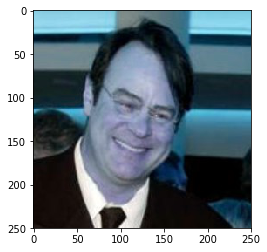

You look like a ...
Dogue de bordeaux


In [45]:
run_app(human_files[0])

---
<a id='step6'></a>
## Step 6: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that _you_ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ (Three possible points for improvement)
- output is better :)
- Increase the no of convolution layers to get more patterns
- increase the depth of hidden layer in MLP (fully connected layer) to get more accurate result
- need to increase no of epoch to tran the model. since i have only limited GPU Hrs so i tried with only lesser Epoch
- I should with Flip with rotation transform for training and validation data loader to improve training

Further i need to play other options like, maxpooling, increasing the stride etc 


hello, human!


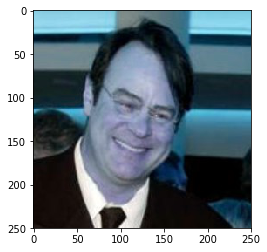

You look like a ...
Dogue de bordeaux

hello, human!


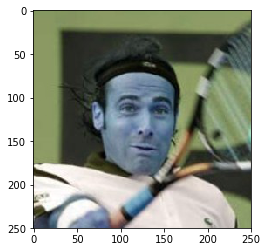

You look like a ...
Dogue de bordeaux

hello, human!


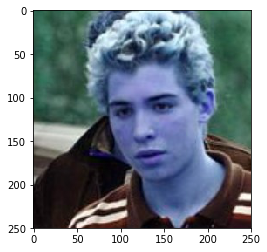

You look like a ...
Poodle

hello, dog!


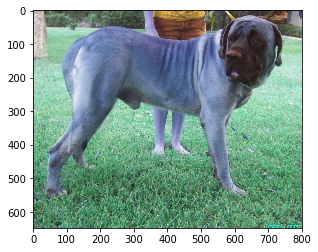

You look like a ...
Mastiff

hello, dog!


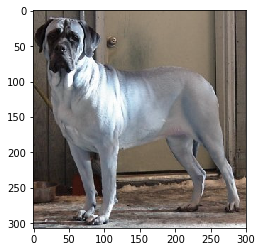

You look like a ...
Mastiff

hello, dog!


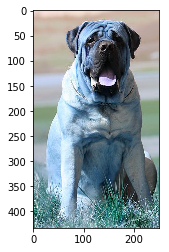

You look like a ...
Mastiff


In [46]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.

## suggested code, below
for file in np.hstack((human_files[:3], dog_files[:3])):
    run_app(file)